## Setup

In [1]:
# cellranger import
#import modules, define some functions for loading, saving and processing a gene-barcode matrix
%matplotlib inline
import pkg_resources
import collections
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import matplotlib
import matplotlib.pyplot as plt
import h5py

np.random.seed(0)

GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            if 'id' in dsets.keys():
                return GeneBCMatrix(dsets['id'], dsets['name'], dsets['barcodes'], matrix)
            else:
                return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")

def save_matrix_to_h5(gbm, filename, genome):
    flt = tables.Filters(complevel=1)
    with tables.open_file(filename, 'w', filters=flt) as f:
        try:
            group = f.create_group(f.root, genome)
            f.create_carray(group, 'genes', obj=gbm.gene_ids)
            f.create_carray(group, 'gene_names', obj=gbm.gene_names)
            f.create_carray(group, 'barcodes', obj=gbm.barcodes)
            f.create_carray(group, 'data', obj=gbm.matrix.data)
            f.create_carray(group, 'indices', obj=gbm.matrix.indices)
            f.create_carray(group, 'indptr', obj=gbm.matrix.indptr)
            f.create_carray(group, 'shape', obj=gbm.matrix.shape)
        except:
            raise Exception("Failed to write H5 file.")
        
def subsample_matrix(gbm, barcode_indices):
    return GeneBCMatrix(gbm.gene_ids, gbm.gene_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

def get_expression(gbm, gene_name):
    gene_indices = np.where(gbm.gene_names == gene_name)[0]
    if len(gene_indices) == 0:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()

def save_count_matrix_to_h5(E, gene_list, filename):
    with h5py.File(filename, 'w') as hf:
        hf.create_dataset("indptr" ,  data= E.indptr)
        hf.create_dataset("indices",  data= E.indices)
        hf.create_dataset("data"   ,  data= E.data)
        hf.create_dataset("shape"  ,  data= E.shape)
        hf.create_dataset("genes"  ,  data= gene_list)

In [2]:
%pylab inline
from helper_functions import *
#from doublet_detector import *
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [3]:
#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
# download raw data from 10X Genomics
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_raw_feature_bc_matrix.h5

--2021-02-10 18:50:02--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_raw_feature_bc_matrix.h5
Resolving cp-tinyproxy.default.svc.cluster.local (cp-tinyproxy.default.svc.cluster.local)... 10.105.184.90
Connecting to cp-tinyproxy.default.svc.cluster.local (cp-tinyproxy.default.svc.cluster.local)|10.105.184.90|:3128... connected.
Proxy request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_raw_feature_bc_matrix.h5 [following]
--2021-02-10 18:50:04--  https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_raw_feature_bc_matrix.h5
Connecting to cp-tinyproxy.default.svc.cluster.local (cp-tinyproxy.default.svc.cluster.local)|10.105.184.90|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 154515158 (147M) [binary/octet-stream]
Saving to: 'pbmc_10k_protein_v3_raw_feature_bc_matrix.h5.2'

pb

## Load data

In [5]:
# D stores all the data; one entry per library
sample_list = ["Sample1"]
D = {}

for j, s in enumerate(sample_list):
    filename = 'pbmc_10k_protein_v3_raw_feature_bc_matrix.h5'
    raw_matrix_h5 = filename
    print raw_matrix_h5
    genome = "matrix"
    D[s] = {}
    D[s]['meta'] = {}
    gbm = get_matrix_from_h5(raw_matrix_h5, genome)
    D[s]['E'] = transpose(gbm.matrix)
    D[s]['meta']['gene_list']=gbm.gene_names
    D[s]['meta']['gene_id']=gbm.gene_ids
    print D[s]['E'].shape
    D[s]['cell_index']=gbm.barcodes
    print (len(D[s]['cell_index']))

pbmc_10k_protein_v3_raw_feature_bc_matrix.h5
(6794880, 33555)
6794880


In [6]:
gene_list = D[s]['meta']['gene_list']
gene_id = D[s]['meta']['gene_id']

In [7]:
# get protein names and gene names

adt_ix = [i for i,g in enumerate(gene_list) if g.endswith('TotalSeqB')]
gn_ix = [i for i,g in enumerate(gene_list) if not g.endswith('TotalSeqB')]

print [gene_list[i] for i in adt_ix]
proteins = gene_list[adt_ix]
gns = gene_list[gn_ix]

['CD3_TotalSeqB', 'CD4_TotalSeqB', 'CD8a_TotalSeqB', 'CD14_TotalSeqB', 'CD15_TotalSeqB', 'CD16_TotalSeqB', 'CD56_TotalSeqB', 'CD19_TotalSeqB', 'CD25_TotalSeqB', 'CD45RA_TotalSeqB', 'CD45RO_TotalSeqB', 'PD-1_TotalSeqB', 'TIGIT_TotalSeqB', 'CD127_TotalSeqB', 'IgG2a_control_TotalSeqB', 'IgG1_control_TotalSeqB', 'IgG2b_control_TotalSeqB']


## Filter cells by total counts and number of genes detected


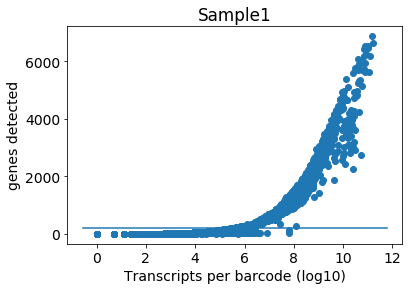

In [8]:
# plot total counts histograms - don't actually filter out any barcodes yet


# adjust total counts thresholds

for j,s in enumerate(sample_list):
    D[s]['total_counts'] = np.sum(D[s]['E'][:,gn_ix], axis=1).A[:,0]
    D[s]['genes_detected'] = np.sum(D[s]['E'][:,gn_ix]>0, axis=1).A[:,0]
    D[s]['meta']['min_tot']= np.mean(D[s]['total_counts'])+np.std(D[s]['total_counts'])
    D[s]['meta']['min_genes_detected']=200;

    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    ax3.set_xlabel('Transcripts per barcode (log10)')
    ax3.set_ylabel('genes detected')

    ax3.scatter(log(1 + D[s]['total_counts']),D[s]['genes_detected']);
    ax3.plot(ax3.get_xlim(),[D[s]['meta']['min_genes_detected'],D[s]['meta']['min_genes_detected']]);
    title(s)

In [9]:
D_orig=D
for j,s in enumerate(sample_list):
    ix = (D[s]['genes_detected'] > 200) & (D[s]['total_counts'] > 500)
    print D_orig[s]['E'].shape[0]
    if np.sum(ix) > 0:
        print s, np.sum(ix), '/', D[s]['E'].shape[0], np.median(D[s]['total_counts'][ix]), np.mean(D[s]['total_counts'][ix])


6794880
Sample1 7965 / 6794880 3628.0 4664.67507847


In [10]:
# Actually filter out low-count barcodes
for j,s in enumerate(sample_list):
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    tmpfilt = np.nonzero((D[s]['genes_detected'] > 200) & (D[s]['total_counts'] > 500))[0]
    print max(tmpfilt)
    print D[s]['E'].shape
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    print D[s]['E'].shape



---  Sample1 ---
Pre-filter: 6794880 barcodes
6794372
(6794880, 33555)
Post-filter: 7965 barcodes
(7965, 33555)


## Filter cells by mito fraction

In [11]:
# get mitochondrial genes
mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('MT-')]
print [gene_list[i] for i in mt_ix]

['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


7965 7902


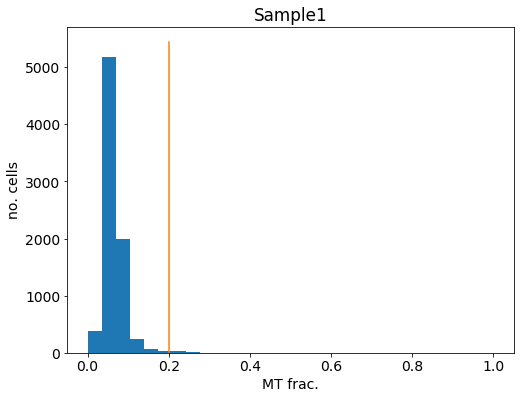

In [12]:
# plot mito-gene frac histograms - don't actually filter out any cells yet
# set mito-gene frac threshold
for j,s in enumerate(sample_list):
    D[s]['meta']['max_mt'] = 0.2

for j,s in enumerate(sample_list):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, xscale='linear', yscale='linear',
        xlabel='MT frac.', ylabel='no. cells')

    D[s]['mito_frac'] = np.sum(D[s]['E'][:,mt_ix], axis=1).A[:,0] / np.sum(D[s]['E'][:,gn_ix], axis=1,dtype=float).A[:,0]

    ax.hist(D[s]['mito_frac'], cumulative=False, 
            bins=np.linspace(0, 1, 30))

    ax.plot([D[s]['meta']['max_mt'],D[s]['meta']['max_mt']],ax.get_ylim());
    title(s)

    print D[s]['E'].shape[0], np.sum(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])


In [13]:
# Actually filter out mito-high cells 
D_filt=D
for s in sample_list:
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    tmpfilt = np.nonzero(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])[0]
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    
#del tmpfilt

---  Sample1 ---
Pre-filter: 7965 barcodes
Post-filter: 7902 barcodes


## Merge data, normalize

In [14]:
# create master dataset (all SPRING subsets will refer back to this)

samp_lookup = {}
samp_id_flat = np.array([],dtype=str)

for s in D.keys():
    samp_id_flat = np.append(samp_id_flat, [s] * D[s]['E'].shape[0])

        
E = scipy.sparse.lil_matrix((len(samp_id_flat), len(gene_list)), dtype=int)
total_counts = np.zeros(len(samp_id_flat), dtype=int)
mito_frac = np.zeros(len(samp_id_flat), dtype=float)
genes_detected = np.zeros(len(samp_id_flat), dtype=int)

for s in D.keys():
    print s
    E[samp_id_flat == s, :] = D[s]['E']
    total_counts[samp_id_flat == s] = D[s]['total_counts']
    mito_frac[samp_id_flat == s] = D[s]['mito_frac']
    genes_detected[samp_id_flat == s] = D[s]['genes_detected']

E = E.tocsc()

Sample1


In [15]:
E_full=E

In [16]:
# remove genes that are not expressed by any cells
# optionally remove mito and rps genes
gene_list = D[sample_list[0]]['meta']['gene_list']
gene_id = D[sample_list[0]]['meta']['gene_id']
remove_crapgenes = 1

if remove_crapgenes:
    import re
    mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('MT-')]
    print [gene_list[i] for i in mt_ix]
    #rp_ix = [i for i,g in enumerate(gene_list) if g.startswith('RPS') or g.startswith('RPL')]
    #rp_ix = [i for i,g in enumerate(gene_list) if g.startswith('RPS','RPL')]
    rp_ix = [i for i,g in enumerate(gene_list) if g.startswith('RP1') 
             or g.startswith('RP2') or g.startswith('RP3')
             or g.startswith('RP4') or g.startswith('RP5')
             or g.startswith('RP6') or g.startswith('RP7')
             or g.startswith('RP8') or g.startswith('RP9')
             or g.startswith('RPL') or g.startswith('RPS')
            ]
    #or g.startswith('RP4','RP5','RP6') or g.startswith('RP7','RP8','RP9')]
    keep_genes = (E.sum(0) > 0).A.squeeze() #* rp_ix * mt_ix
    keep_genes[rp_ix] = 0
    keep_genes[mt_ix] = 0
    print sum(keep_genes), '/', len(keep_genes)
else:
    keep_genes = (E.sum(0) > 0).A.squeeze()
    print sum(keep_genes), '/', len(keep_genes)


['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']
20922 / 33555


In [17]:
# filter out genes
E = E[:,keep_genes]
print shape(E)
gene_list = gene_list[keep_genes]
gene_id = gene_id[keep_genes]
merged_list=[x+"_"+gene_id[i] for i,x in enumerate(gene_list)]

(7902, 20922)


In [18]:
# get protein names and gene names
adt_ix = [i for i,g in enumerate(gene_list) if g.endswith('TotalSeqB')]
gn_ix = [i for i,g in enumerate(gene_list) if not g.endswith('TotalSeqB')]

print [merged_list[i] for i in adt_ix]
proteins = gene_list[adt_ix]
gns = gene_list[gn_ix]
merged_proteins = [merged_list[i] for i in adt_ix]

# normalize by total counts seperately
E[:,gn_ix] = tot_counts_norm_sparse(E[:,gn_ix])[0]

['CD3_TotalSeqB_CD3', 'CD4_TotalSeqB_CD4', 'CD8a_TotalSeqB_CD8a', 'CD14_TotalSeqB_CD14', 'CD15_TotalSeqB_CD15', 'CD16_TotalSeqB_CD16', 'CD56_TotalSeqB_CD56', 'CD19_TotalSeqB_CD19', 'CD25_TotalSeqB_CD25', 'CD45RA_TotalSeqB_CD45RA', 'CD45RO_TotalSeqB_CD45RO', 'PD-1_TotalSeqB_PD-1', 'TIGIT_TotalSeqB_TIGIT', 'CD127_TotalSeqB_CD127', 'IgG2a_control_TotalSeqB_IgG2a', 'IgG1_control_TotalSeqB_IgG1', 'IgG2b_control_TotalSeqB_IgG2b']


## Save base directory files

In [25]:
main_spring_dir=os.getcwd()

In [26]:
# if BCR data
BCR = 1

if BCR:
    barcode_dir = main_spring_dir + "/barcodes/"
    if not os.path.exists(barcode_dir):
        os.makedirs(barcode_dir)
        for s in sample_list:
            print '---  %s ---' %s
            np.savetxt(barcode_dir + s, D[s]['cell_index'], fmt='%s')


In [27]:
MT = 1

if MT:
    MT_dir = main_spring_dir + "/mito/"
    if not os.path.exists(MT_dir):
        os.makedirs(MT_dir)
        for s in sample_list:
            print '---  %s ---' %s
            np.savetxt(MT_dir + s, D[s]['mito_frac'], fmt='%s')

In [28]:
gene_list_new=np.array(merged_list)
np.savetxt(main_spring_dir + '/genes.txt', merged_list, fmt='%s')

In [29]:
# save master expression matrix in hdf5 format
import h5py

print 'Saving hdf5 file for fast gene loading...'
E = E.tocsc()
hf = h5py.File(main_spring_dir + 'counts_norm_sparse_genes.hdf5', 'w')
counts_group = hf.create_group('counts')
cix_group = hf.create_group('cell_ix')

hf.attrs['ncells'] = E.shape[0]
hf.attrs['ngenes'] = E.shape[1]

for iG, g in enumerate(merged_list):
    if iG % 3000 == 0:
        print g, iG, '/', len(merged_list)
    counts = E[:,iG].A.squeeze()
    cell_ix = np.nonzero(counts)[0]
    counts = counts[cell_ix]
    counts_group.create_dataset(g, data = counts)
    cix_group.create_dataset(g, data = cell_ix)

hf.close()

##############

print 'Saving hdf5 file for fast cell loading...'
E = E.tocsr()
hf = h5py.File(main_spring_dir + 'counts_norm_sparse_cells.hdf5', 'w')
counts_group = hf.create_group('counts')
gix_group = hf.create_group('gene_ix')

hf.attrs['ncells'] = E.shape[0]
hf.attrs['ngenes'] = E.shape[1]

for iC in range(E.shape[0]):
    if iC % 3000 == 0:
        print iC, '/', E.shape[0]
    counts = E[iC,:].A.squeeze()
    gene_ix = np.nonzero(counts)[0]
    counts = counts[gene_ix]
    
    counts_group.create_dataset(str(iC), data = counts)
    gix_group.create_dataset(str(iC), data = gene_ix)

hf.close()

Saving hdf5 file for fast gene loading...
AL627309.1_ENSG00000238009 0 / 20922
TANC1_ENSG00000115183 3000 / 20922
PCDHGA1_ENSG00000204956 6000 / 20922
PPP1R3B_ENSG00000173281 9000 / 20922
KCNMA1-AS3_ENSG00000225652 12000 / 20922
USP3-AS1_ENSG00000259248 15000 / 20922
C18orf65_ENSG00000275763 18000 / 20922
Saving hdf5 file for fast cell loading...
0 / 7902
3000 / 7902
6000 / 7902


In [30]:
scipy.io.mmwrite(main_spring_dir + 'matrix.mtx', E)

#### Save merged samples

['Sample1']
1612984906.71
________________ /FullDataset_v1_rna
Filtering genes
Using 986 genes
Excluded 17 genes
Running PCA
Building kNN graph
kNN built in 5.93095 sec
Saving SPRING files to /home/I0369218/precision-immunology/CHAMBERLAIN.Mat/CITESEQ_EXPLORATORY_CITESEQ_5K_PBMCS/FullDataset_v1_rna
Running ForceAtlas2
190.111049891
190.200725079


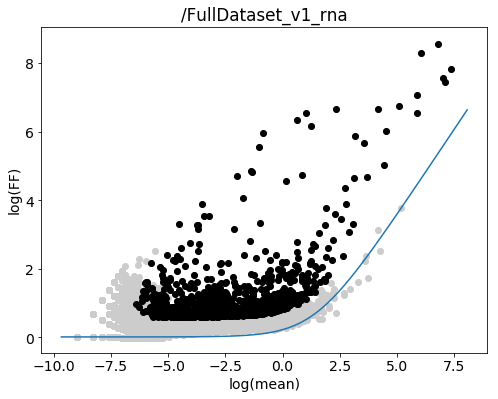

In [31]:
merge_setup = {'/FullDataset_v1_rna':sample_list}

for s, smerge in merge_setup.items():
    print smerge
    t0 = time.time()
    print t0
    print '________________', s
    
    cell_ix = np.in1d(samp_id_flat, smerge)
    
    run_all_spring_1_6(E[cell_ix,:],
                     list(merged_list), s, main_spring_dir, normalize=False, tot_counts_final = total_counts[cell_ix],
                     min_counts = 3, min_cells = 3, min_vscore_pctl = 90, exclude_gene_names = list(merged_proteins),
                     show_vscore_plot = True, num_pc = 60, pca_method = '', k_neigh=4, use_approxnn = False,
                     output_spring = True, num_force_iter = 2000,
                     cell_groupings = {'Sample': list(samp_id_flat[cell_ix])})
    
    print time.time() - t0
    
    np.save(main_spring_dir + s + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(main_spring_dir + s + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')
    
    print time.time() - t0


In [32]:
merge_setup = {'/FullDataset_v1_protein':sample_list}

for s, smerge in merge_setup.items():
    print smerge
    t0 = time.time()
    print t0
    print '________________', s
    
    cell_ix = np.in1d(samp_id_flat, smerge)
    
    run_all_spring_1_6(E[cell_ix,:],
                     list(merged_list), s, main_spring_dir, normalize=True, tot_counts_final = total_counts[cell_ix],
                     min_counts = 3, min_cells = 3, min_vscore_pctl = 90,
                     show_vscore_plot = True, num_pc = 17, pca_method = '', k_neigh=4, use_approxnn = False,
                     output_spring = True, num_force_iter = 2000, gene_filter = adt_ix,
                     cell_groupings = {'Sample': list(samp_id_flat[cell_ix])})
    
    print time.time() - t0
    
    np.save(main_spring_dir + s + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(main_spring_dir + s + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')
    
    print time.time() - t0



['Sample1']
1612985097.21
________________ /FullDataset_v1_protein
Normalizing
Using user-supplied gene filter
Running PCA
Building kNN graph
kNN built in 0.83048 sec
Saving SPRING files to /home/I0369218/precision-immunology/CHAMBERLAIN.Mat/CITESEQ_EXPLORATORY_CITESEQ_5K_PBMCS/FullDataset_v1_protein
Running ForceAtlas2
172.316283941
172.402792931
